## Single Cell Analyzer

This notebook uses scanpy to analyze Drop-seq and 10X single-cell RNA-seq data. The parameters used in this notebook should be approximately accurate for most high-quality datasets. Please inspect the plots to make sure parameters match with the plots.

Steps:

* Pre-processing: filter cells with < 200 genes, genes < 3 cells; remove cells > 2500 genes, > 5% mitochondrial counts
* Normalization: convert counts to log TP10K
* Select highly variable genes (min_mean=0.0125, max_mean=3, min_disp=0.5)
* Perform PCA and keep top 20 PCs
* Louvain clustering, UMAP and tSNE
* Differential expression with a simple t-test
* Visualize differentially expressed genes

In [221]:
import numpy as np
import pandas as pd
import scanpy as sc
import warnings

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=70)
warnings.filterwarnings('ignore')

FILE_10X = '/scratch/midway2/selewa/test2/output/AB-HE191206-OvCa7019-total_S5_Solo.out/Gene/filtered/'

scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [222]:
# Load data
scanpy_obj = sc.read_10x_mtx(FILE_10X, cache=True)
scanpy_obj.var_names_make_unique(join='-')

# basic filtering
sc.pp.filter_cells(scanpy_obj, min_genes=200)
sc.pp.filter_genes(scanpy_obj, min_cells=3)

In [223]:
# calculate mitochondrial gene fraction
mito_genes = scanpy_obj.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
scanpy_obj.obs['percent_mito'] = np.sum(
    scanpy_obj[:, mito_genes].X, axis=1) / np.sum(scanpy_obj.X, axis=1)
# add the total counts per cell as observations-annotation to adata
scanpy_obj.obs['n_counts'] = scanpy_obj.X.sum(axis=1)

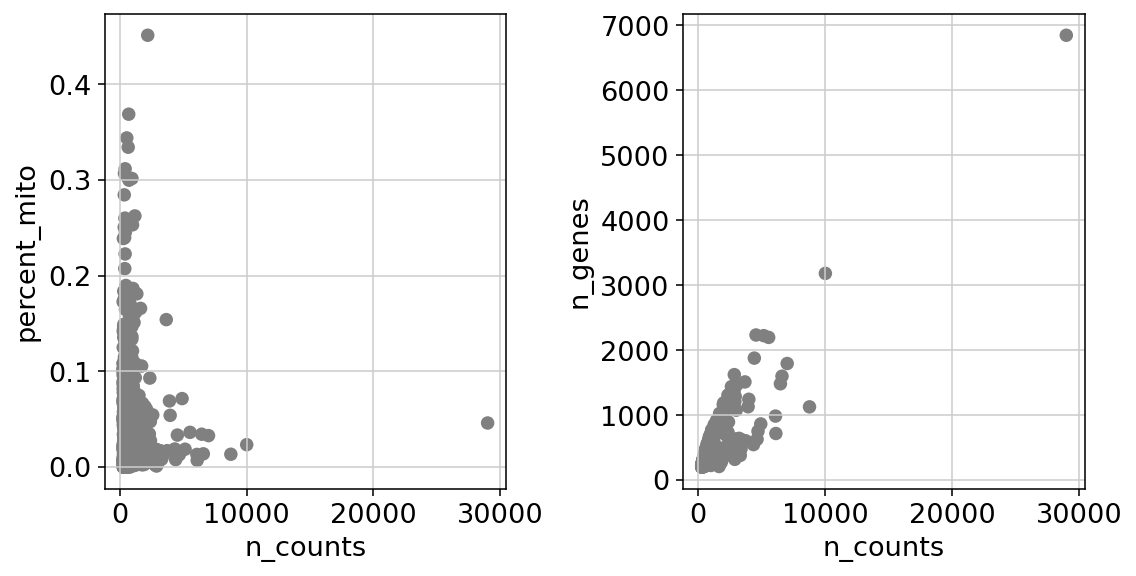

In [225]:
fig, axs = plt.subplots(1,2, figsize=(8,4),constrained_layout=True)
sc.pl.scatter(scanpy_obj, x='n_counts', y='percent_mito', ax=axs[0], show=False)
sc.pl.scatter(scanpy_obj, x='n_counts', y='n_genes', ax=axs[1], show=False)
plt.show()

In [226]:
# filter based on plots above
scanpy_obj = scanpy_obj[scanpy_obj.obs.n_genes < 2500, :]
scanpy_obj = scanpy_obj[scanpy_obj.obs.percent_mito < 0.05, :]

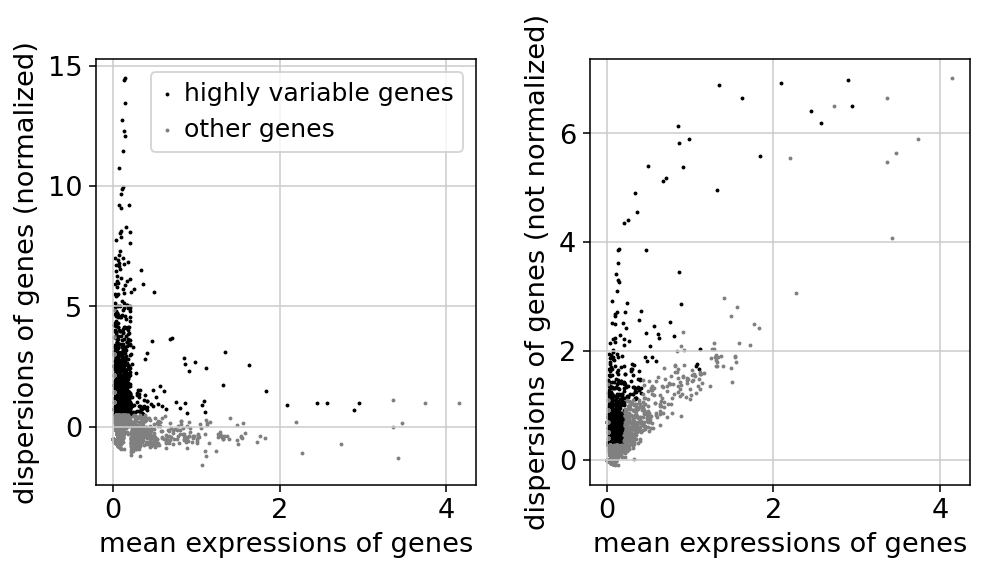

In [227]:
# Normalize to log TP10K
sc.pp.normalize_total(scanpy_obj, target_sum=1e4)
sc.pp.log1p(scanpy_obj)

# Subset by highly variable genes
sc.pp.highly_variable_genes(scanpy_obj, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(scanpy_obj)

In [228]:
scanpy_obj = scanpy_obj[:, scanpy_obj.var.highly_variable]

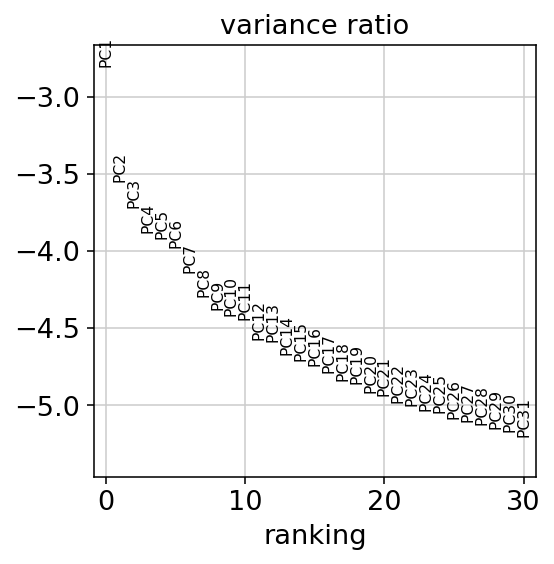

In [229]:
#sc.pp.regress_out(scanpy_obj, ['n_counts', 'percent_mito'])
sc.pp.scale(scanpy_obj, max_value=10)
sc.tl.pca(scanpy_obj, svd_solver='arpack')
sc.pl.pca_variance_ratio(scanpy_obj, log=True)

In [230]:
sc.pp.neighbors(scanpy_obj, n_neighbors=10, n_pcs=20)
sc.tl.umap(scanpy_obj)
sc.tl.tsne(scanpy_obj)

In [231]:
sc.tl.louvain(scanpy_obj)

In [232]:
sc.tl.rank_genes_groups(scanpy_obj, 'louvain', method='t-test')

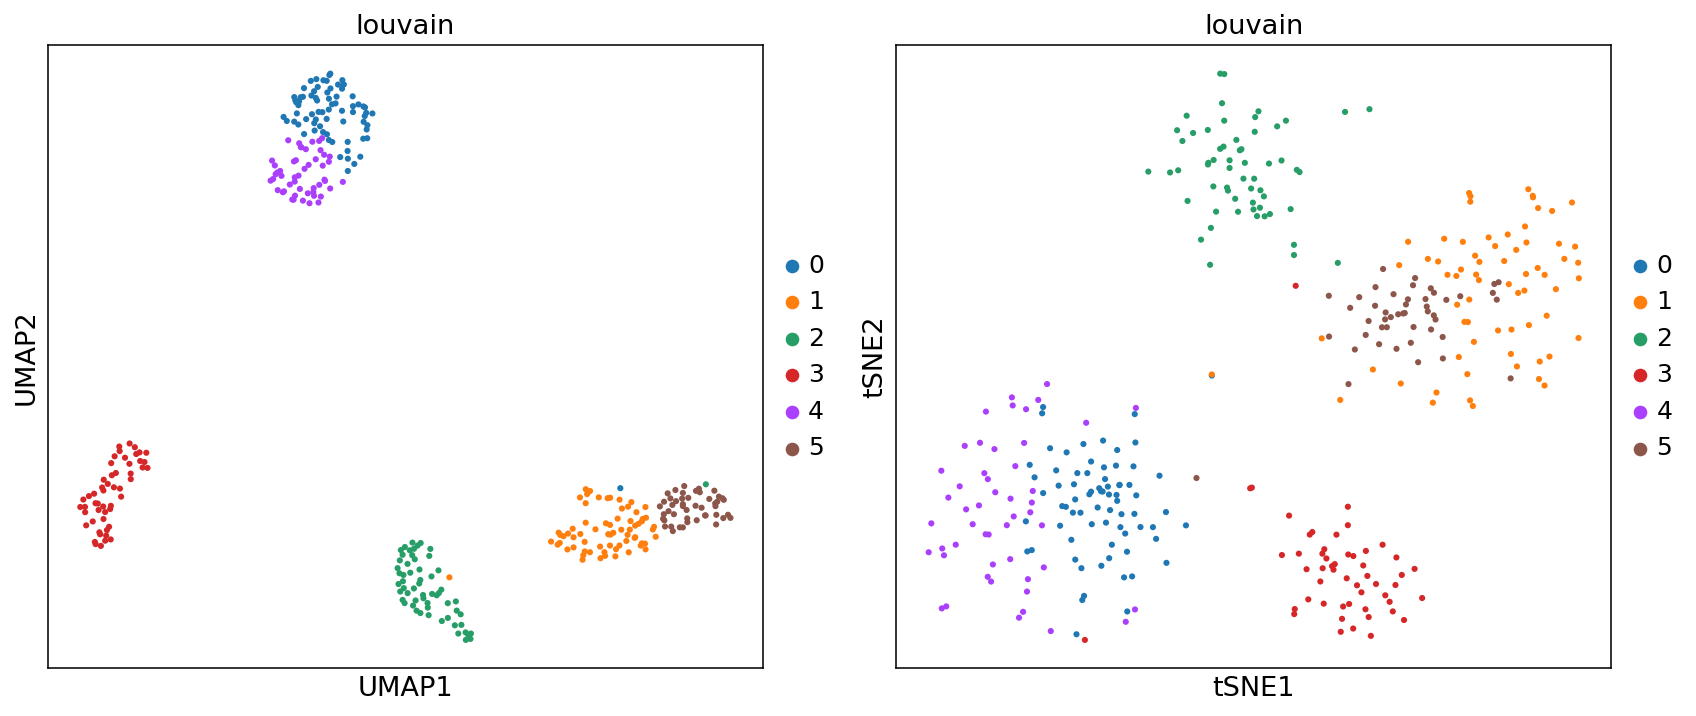

In [238]:
fig, axs = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
sc.pl.umap(scanpy_obj, color='louvain', size=40, ax=axs[0], show=False)
sc.pl.tsne(scanpy_obj, color='louvain', size=40, ax=axs[1], show=False)
plt.show()

In [239]:
sc.tl.rank_genes_groups(scanpy_obj, 'louvain', method='t-test')
marker_genes_df = dict(pd.DataFrame(scanpy_obj.uns['rank_genes_groups']['names']).head(10))

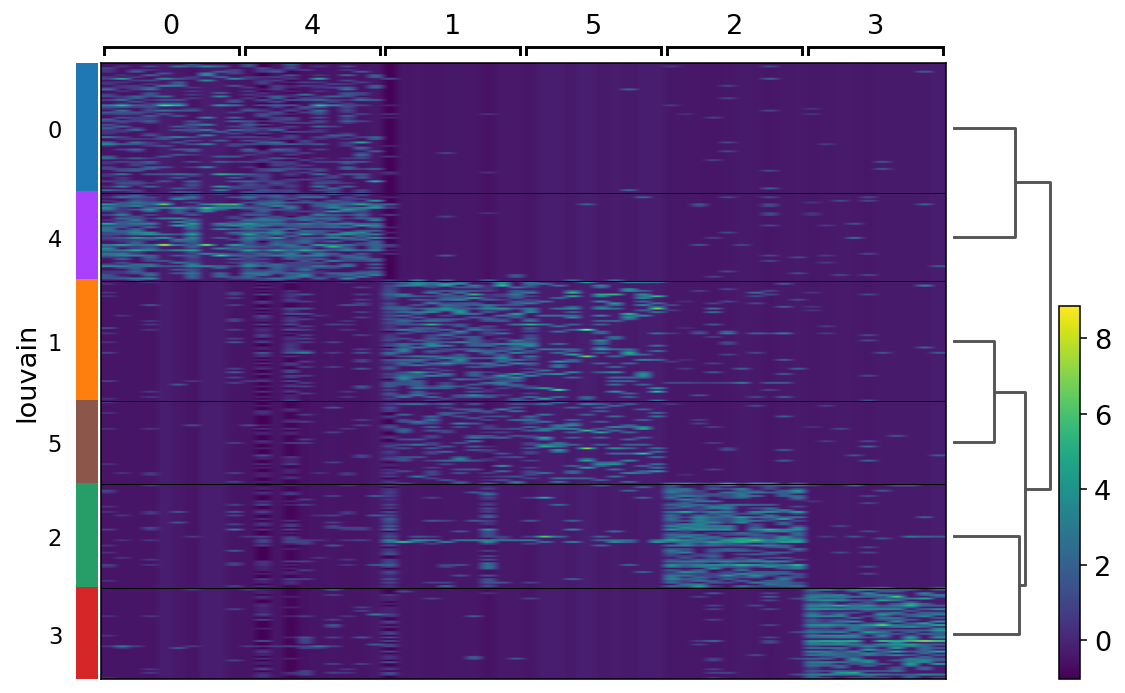

In [240]:
ax = sc.pl.heatmap(scanpy_obj, marker_genes_df, groupby='louvain', dendrogram=True)